## GROUP 4 
## TEAM MEMBER
### Anub Rai; Dengyi Liu; Xin Xiang; Yuchen Wang

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_player = pd.read_csv('https://raw.githubusercontent.com/ycwang15/Rec_Sys_assignments/main/Final_Project/DATA/player_score2%20-%20player_score2.csv')
df_player.head()

,Player,Nation,Squad,score
0,Patrick van Aanholt,NED,Crystal Palace,70.42
1,Rolando Aarons,ENG,Hellas Verona,15.42
2,Ignazio Abate,ITA,Milan,36.83
3,Aymen Abdennour,TUN,Marseille,14.79
4,Mehdi Abeid,ALG,Dijon,46.55


In [3]:
print(df_player.shape)
print(df_player['Player'].nunique())

(5386, 4)
3722


In [4]:
from keras.utils.np_utils import to_categorical

# We have 10 users, each is uniquely identified by an ID.
players = [i for i in range(df_player['Player'].nunique())]
to_categorical(players)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [5]:
##Now I need an embedding weight matrix which will map a user or movie to an embedding vector. 
## Let's define the embedding matrix to be a matrix of shape (N, D) where N is the number of users or movies and D is the latent dimension of embedding.
import numpy as np

latent_dim = 5
inputs = to_categorical(players)
embed_mat = np.random.randn(len(players), latent_dim)

inputs.dot(embed_mat)

array([[ 1.71479856, -0.86849105,  0.46169311,  0.20922703,  0.4978053 ],
       [-0.68645056,  0.04490699,  0.65367404, -0.70902073, -0.60160413],
       [ 0.14740322,  0.11838937, -0.04253221, -0.14842258, -0.57815596],
       ...,
       [ 0.35782795, -0.67922007, -1.73299615, -1.19006274, -0.19955079],
       [ 1.91902602, -0.03866726, -0.41601912,  0.1287636 , -1.12134247],
       [-0.6803242 , -0.57593431, -0.83361108, -0.79318573, -1.57453088]])

In [6]:
from sklearn.model_selection import train_test_split
num_team = len(df_player.Squad.unique())
num_player = len(df_player.Player.unique())
print('unique number of team is : {}'.format(num_team))
print('unique number of player is : {}'.format(num_player))

df_player = df_player[['Player','Squad','score']]

from sklearn.preprocessing import LabelEncoder
L_Player = LabelEncoder()
df_player['Player'] = L_Player.fit_transform(df_player['Player'])
L_Team = LabelEncoder()
df_player['Squad'] = L_Player.fit_transform(df_player['Squad'])

train, test = train_test_split(df_player, test_size=0.2)

unique number of team is : 135
unique number of player is : 3722


<ipython-input-6-f2ad22ae6424>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_player['Player'] = L_Player.fit_transform(df_player['Player'])
<ipython-input-6-f2ad22ae6424>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_player['Squad'] = L_Player.fit_transform(df_player['Squad'])


In [7]:
df_player.head()

,Player,Squad,score
0,2802,31,70.42
1,3037,54,15.42
2,1402,83,36.83
3,357,81,14.79
4,2440,33,46.55


## Generalized Matrix Factorization (GMF)

In [8]:
#!pip install --upgrade keras

In [9]:
#!pip install --upgrade pydot

In [10]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input
from keras.layers import concatenate
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
import tensorflow as tf

# Let's use a higher latent dimension.
latent_dim = 10

player_input = Input(shape=[1],name='player-input')
player_embedding = Embedding(num_player + 1, latent_dim, name='player-embedding')(player_input)
player_vec = Flatten(name='player-flatten')(player_embedding)

team_input = Input(shape=[1],name='team-input')
team_embedding = Embedding(num_team + 1, latent_dim, name='team-embedding')(team_input)
team_vec = Flatten(name='team-flatten')(team_embedding)

prod = concatenate([player_vec, team_vec],name='dot-product')

model = Model([team_input, player_input], prod)
model.compile('adam', 'mean_squared_error')



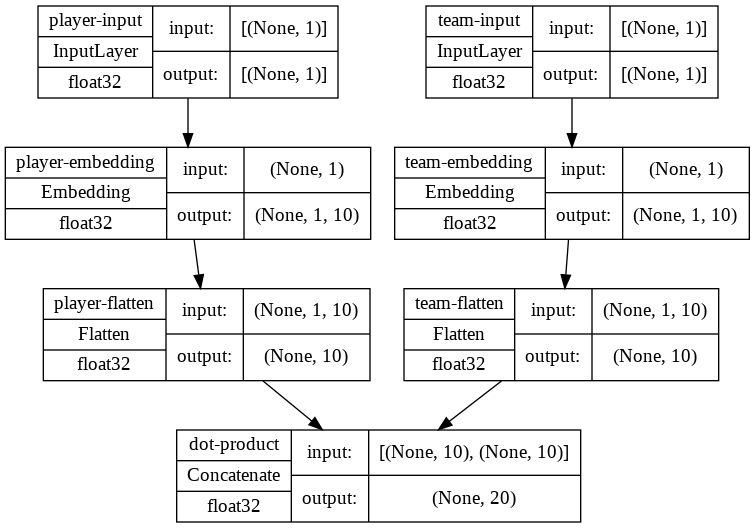

In [11]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    #rankdir='TB',
    #expand_nested=False,
    #dpi=96,
    #layer_range=None,
    #show_layer_activations=False
)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 player-input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 team-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 player-embedding (Embedding)   (None, 1, 10)        37230       ['player-input[0][0]']           
                                                                                                  
 team-embedding (Embedding)     (None, 1, 10)        1360        ['team-input[0][0]']             
                                                                                              

* In the model above, we are not using any activation function and there is no additional weight to layer. The model above represents a classic matrix factorization. It takes two inputs, a TEAM ID and a PLAYER ID. The inputs are embedded into (1, 5) vectors. The vectors are then flattened. The dot product of the flattened vectors is the predicted rating.

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_error')

Epoch 1/10
135/135 [==============================] - 2s 4ms/step - loss: 2530.6257
Epoch 2/10
135/135 [==============================] - 1s 5ms/step - loss: 2501.1833
Epoch 3/10
135/135 [==============================] - 1s 4ms/step - loss: 2471.7095
Epoch 4/10
135/135 [==============================] - 0s 4ms/step - loss: 2442.5735
Epoch 5/10
135/135 [==============================] - 1s 5ms/step - loss: 2413.8513
Epoch 6/10
135/135 [==============================] - 0s 4ms/step - loss: 2385.5706
Epoch 7/10
135/135 [==============================] - 0s 3ms/step - loss: 2357.6851
Epoch 8/10
135/135 [==============================] - 1s 4ms/step - loss: 2330.2444
Epoch 9/10
135/135 [==============================] - 0s 4ms/step - loss: 2303.2334
Epoch 10/10
135/135 [==============================] - 1s 4ms/step - loss: 2276.6763


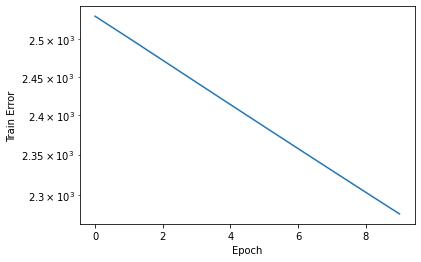

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
history = model.fit([train.Squad, train.Player], train.score, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

### Making it a non-negative matrix factorization by adding a non-negativity constraints on embeddings.

In [15]:
from keras.constraints import non_neg

latent_dim = 5

player_input = Input(shape=[1],name='player-input')
player_embedding = Embedding(num_player + 1, latent_dim, name='movie-embedding',
                                                        embeddings_constraint=non_neg())(player_input)
player_vec = Flatten(name='player-flatten')(player_embedding)

team_input = Input(shape=[1],name='team-input')
team_embedding = Embedding(num_team + 1, latent_dim, name='team-embedding',
                                                      embeddings_constraint=non_neg())(team_input)
team_vec = Flatten(name='team-flatten')(team_embedding)

prod = concatenate([player_vec, team_vec],name='dot-product')

model = Model([team_input, player_input], prod)
model.compile('adam', 'mean_squared_error')

* Now let's add some non-linearities to make it non-linear matrix factorization, which is essentially appending a neural network to the end of the model.

## Nerual Collaborative Filtering

In [16]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dense
from tensorflow.keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import concatenate
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
import tensorflow as tf

latent_dim = 10

player_input = Input(shape=[1],name='player-input')
player_embedding = Embedding(num_player + 1, latent_dim, name='player-embedding')(player_input)
player_vec = Flatten(name='player-flatten')(player_embedding)

team_input = Input(shape=[1],name='team-input')
team_embedding = Embedding(num_team + 1, latent_dim, name='team-embedding')(team_input)
team_vec = Flatten(name='team-flatten')(team_embedding)

concat = concatenate([player_vec, team_vec], name='player-team-concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat)
fc_1_dropout = Dropout(0.2, name='fc-1-dropout')(fc_1)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_dropout = Dropout(0.2, name='fc-2-dropout')(fc_2)
fc_3 = Dense(1, name='fc-3', activation='relu')(fc_2_dropout)


model = Model([team_input, player_input], fc_3)
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


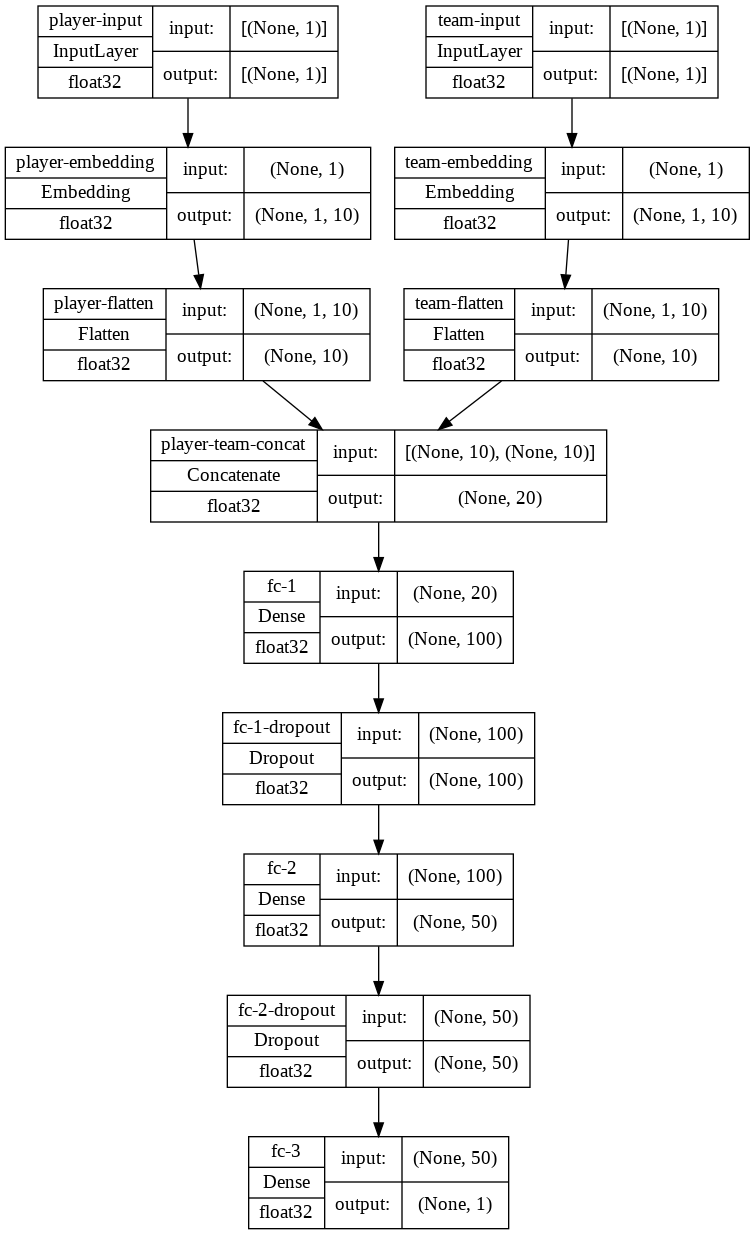

In [17]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    #rankdir='TB',
    #expand_nested=False,
    #dpi=96,
    #layer_range=None,
    #show_layer_activations=False
)

In [18]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 player-input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 team-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 player-embedding (Embedding)   (None, 1, 10)        37230       ['player-input[0][0]']           
                                                                                                  
 team-embedding (Embedding)     (None, 1, 10)        1360        ['team-input[0][0]']             
                                                                                            

Epoch 1/30
135/135 [==============================] - 2s 5ms/step - loss: 1839.4862
Epoch 2/30
135/135 [==============================] - 1s 7ms/step - loss: 558.4630
Epoch 3/30
135/135 [==============================] - 1s 6ms/step - loss: 444.7591
Epoch 4/30
135/135 [==============================] - 1s 7ms/step - loss: 277.7425
Epoch 5/30
135/135 [==============================] - 1s 6ms/step - loss: 206.1119
Epoch 6/30
135/135 [==============================] - 1s 5ms/step - loss: 178.6463
Epoch 7/30
135/135 [==============================] - 1s 5ms/step - loss: 170.5670
Epoch 8/30
135/135 [==============================] - 1s 6ms/step - loss: 166.9356
Epoch 9/30
135/135 [==============================] - 1s 6ms/step - loss: 157.4463
Epoch 10/30
135/135 [==============================] - 1s 6ms/step - loss: 151.0612
Epoch 11/30
135/135 [==============================] - 1s 6ms/step - loss: 152.0998
Epoch 12/30
135/135 [==============================] - 1s 7ms/step - loss: 146.0941


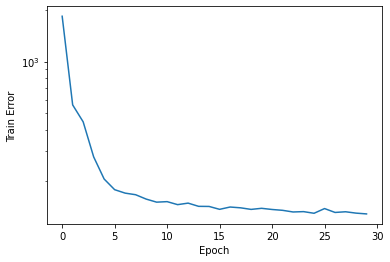

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
history = model.fit([train.Squad, train.Player], train.score, epochs=30)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

## Multi-Layer Perceptron

In [20]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dense
from tensorflow.keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import concatenate
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

latent_dim = 10

# Define inputs
player_input = Input(shape=[1],name='player-input')
team_input = Input(shape=[1], name='team-input')

# MLP Embeddings
player_embedding_mlp = Embedding(num_player + 1, latent_dim, name='player-embedding-mlp')(player_input)
player_vec_mlp = Flatten(name='flatten-player-mlp')(player_embedding_mlp)

team_embedding_mlp = Embedding(num_team + 1, latent_dim, name='team-embedding-mlp')(team_input)
team_vec_mlp = Flatten(name='flatten-team-mlp')(team_embedding_mlp)

# MF Embeddings
player_embedding_mf = Embedding(num_player + 1, latent_dim, name='player-embedding-mf')(player_input)
player_vec_mf = Flatten(name='flatten-player-mf')(player_embedding_mf)

team_embedding_mf = Embedding(num_team + 1, latent_dim, name='team-embedding-mf')(team_input)
team_vec_mf = Flatten(name='flatten-team-mf')(team_embedding_mf)

# MLP layers
concat = concatenate([player_vec_mlp, team_vec_mlp], name='concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

In [21]:
# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = concatenate([player_vec_mf, team_vec_mf], name='pred-mf')
combine_mlp_mf = concatenate([pred_mf, pred_mlp], name='combine-mlp-mf')


In [22]:
# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([team_input, player_input], result)
model.compile(optimizer=Adam(lr=0.001), loss='mean_absolute_error')


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


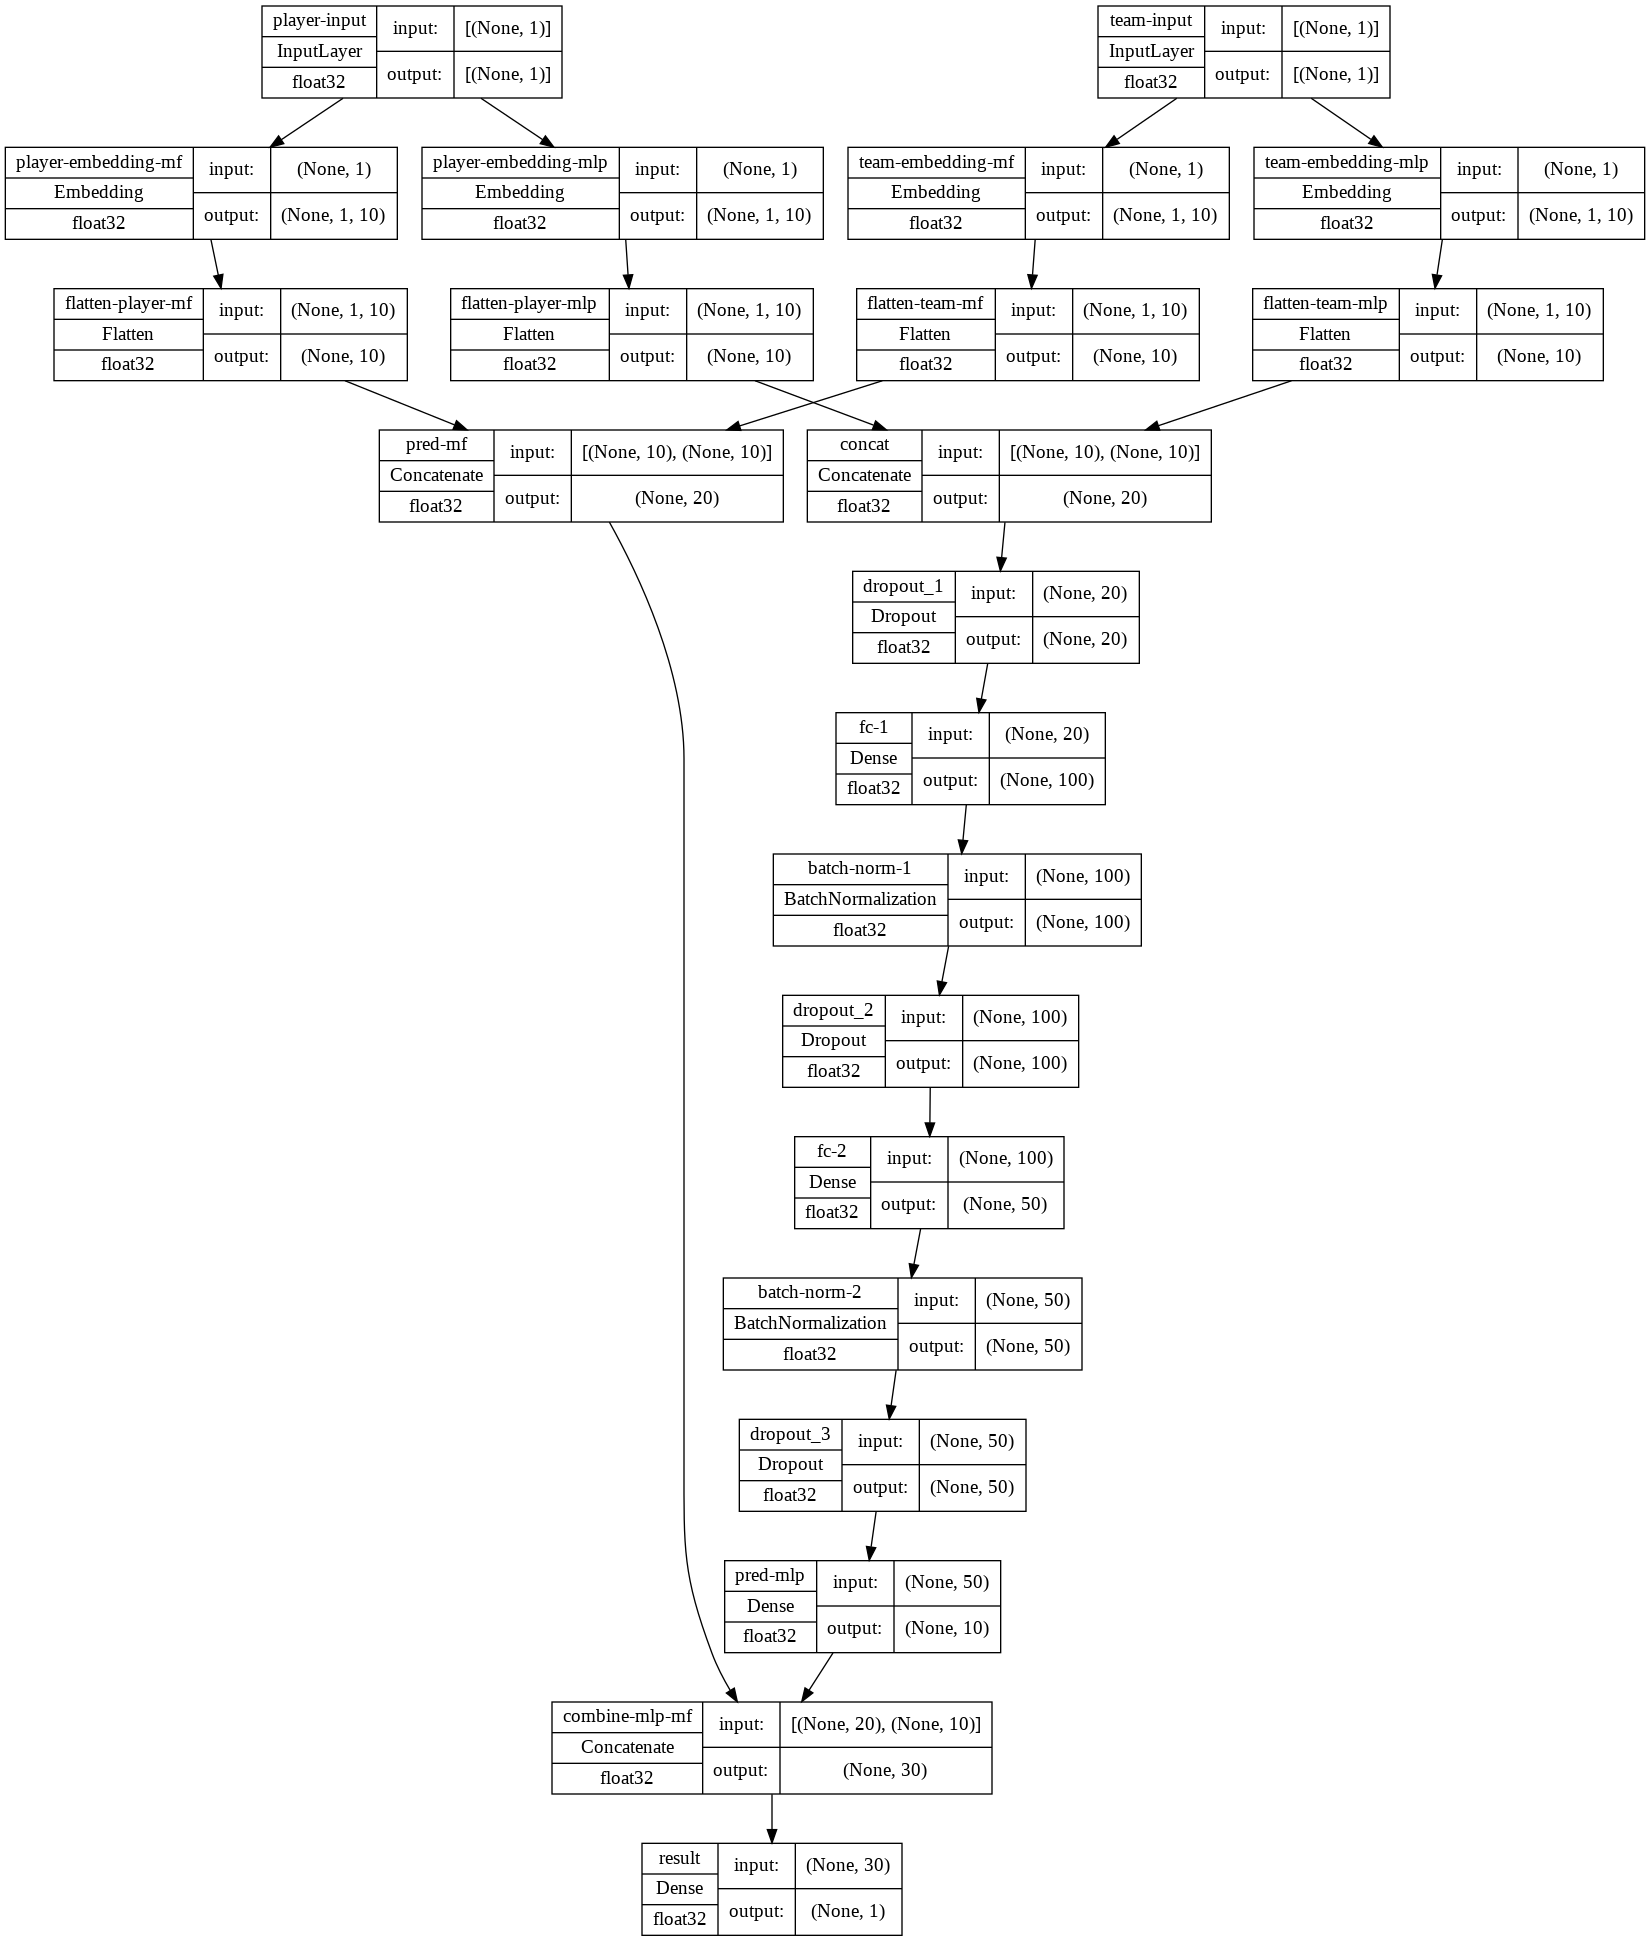

In [23]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    #rankdir='TB',
    #expand_nested=False,
    #dpi=96,
    #layer_range=None,
    #show_layer_activations=False
)

In [24]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 player-input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 team-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 player-embedding-mlp (Embeddin  (None, 1, 10)       37230       ['player-input[0][0]']           
 g)                                                                                               
                                                                                                  
 team-embedding-mlp (Embedding)  (None, 1, 10)       1360        ['team-input[0][0]']       

Epoch 1/100
135/135 [==============================] - 2s 3ms/step - loss: 41.4285
Epoch 2/100
135/135 [==============================] - 0s 4ms/step - loss: 29.2967
Epoch 3/100
135/135 [==============================] - 0s 3ms/step - loss: 22.2502
Epoch 4/100
135/135 [==============================] - 0s 4ms/step - loss: 19.0190
Epoch 5/100
135/135 [==============================] - 0s 4ms/step - loss: 16.3787
Epoch 6/100
135/135 [==============================] - 1s 4ms/step - loss: 14.9254
Epoch 7/100
135/135 [==============================] - 0s 4ms/step - loss: 13.9505
Epoch 8/100
135/135 [==============================] - 0s 3ms/step - loss: 12.6986
Epoch 9/100
135/135 [==============================] - 0s 3ms/step - loss: 12.0866
Epoch 10/100
135/135 [==============================] - 0s 4ms/step - loss: 11.5031
Epoch 11/100
135/135 [==============================] - 0s 3ms/step - loss: 11.3929
Epoch 12/100
135/135 [==============================] - 0s 3ms/step - loss: 10.9023
E

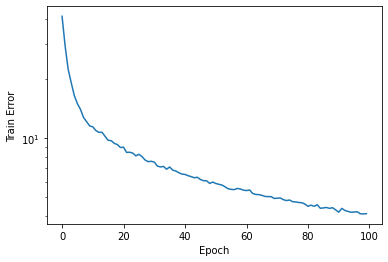

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
history = model.fit([train.Squad, train.Player], train.score, epochs=100)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()